# Подготовительные работы

In [1]:
import numpy as np

In [2]:
log_space=np.logspace(-6,6,3,endpoint=True)

In [3]:
from gzip import open # NB: overrides standard open()
import pickle as pkl
import tensorly as tl
from tensorly.base import tensor_to_vec,  partial_tensor_to_vec
import pandas as pd
import warnings 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
from glob import glob
import os
import math
import functools

In [4]:
warnings.simplefilter('ignore') # отключим предупреждения Anaconda

# Применяем алгоритм построения модели

In [23]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))
print(Xdata_numpy['emission'].shape)

(206,)


In [24]:
#разворачиваем тензор
Xdata_numpy['X'].shape = (Xdata_numpy['X'].shape[0], Xdata_numpy['X'].shape[1] * Xdata_numpy['X'].shape[2])
Xdata_numpy['X'][:,np.isnan(Xdata_numpy['X']).any(axis = 0)] = 0 # zero out any columns containing NaN

In [25]:
#делим набор на обучающий и тестовый
X_train, X_test, y_train, y_test = train_test_split(
     Xdata_numpy['X'], Ydata.iloc[:,0], test_size=0.1428
)
print(X_train.shape)
print(y_train.shape)

(30, 11330)
(30,)


### Чтобы получить все 3 значения R2 нужно проводить обучение в цикле. 

In [512]:
r2_c=[]
r2_cv=[]
r2_p=[]

In [513]:
for i in range(1,21):
    pls1 = PLSRegression()
    parametrsNames={
        'copy': [True], 
        'max_iter': [10000], 
        'n_components': [i], 
        'scale': [False], 
        'tol': [1e-06]
    }
    gridCought=GridSearchCV(pls1, parametrsNames, cv=5,return_train_score=True)
    gridCought.fit(X_train,y_train)
    r2_p+=[gridCought.score(X_test, y_test)]
    r2_cv+=[gridCought.cv_results_[ "mean_test_score" ]]
    r2_c+=[gridCought.cv_results_[ "mean_train_score" ]]

In [514]:
#plt.plot(r2_p,".", color="green")
#plt.plot(r2_c, ".", color="blue")
#plt.plot(r2_cv,".", color="red")
#plt.show()

In [515]:
max(r2_cv)

array([0.9078837])

## Делаем красивый график R2 и сохраняем его 

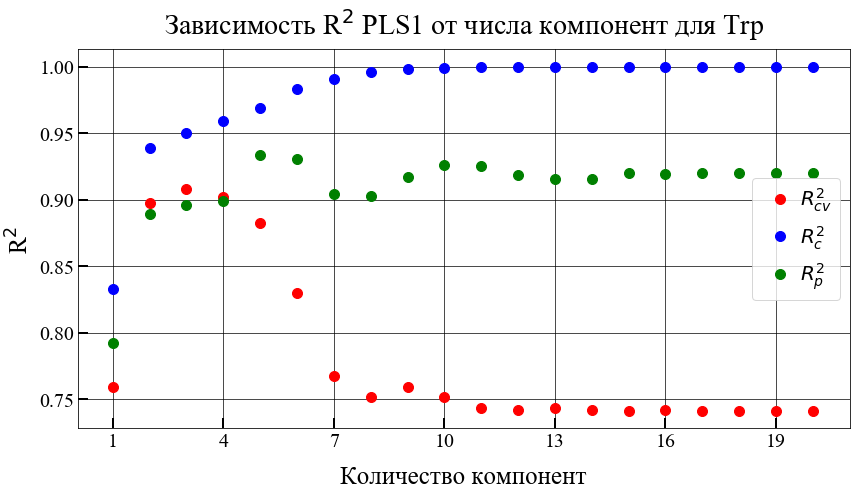

In [521]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(r2_cv,".",color="red",ms=20,label='$R_{cv}^{2}$')
axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,22,3)) # Задаём места, где будет сетка и метки по оси ох

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ PLS1 от числа компонент для Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,23,3), fontsize=20)
axs.set_yticklabels(['0.70','0.75','0.80','0.85','0.90','0.95','1.00','1.050','0.80','1.00','1.20','1.25'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('PLS1 Trp.png', format='png', dpi=1024)


plt.show();

## Сохраним все результаты в пикль формате 

In [522]:
pkl.dump(
	{'r2_cv': r2_cv, 'r2_c': r2_c, 'r2_p': r2_p},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/r2_Trp.pkl.gz', 'wb')
)

### Здесь будут графики введено-найдено

In [26]:
pls1 = PLSRegression()
parametrsNames={
    'copy': [True], 
    'max_iter': [10000], 
    'n_components': [3], 
    'scale': [False], 
    'tol': [1e-06]
}

In [27]:
gridCought=GridSearchCV(pls1, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(X_train,y_train)
predictors=gridCought.predict(X_test)

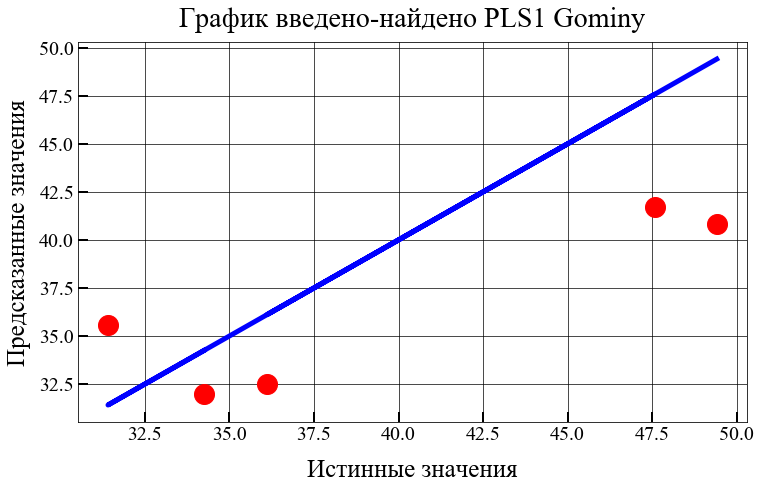

In [30]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(y_test,predictors,".",color="red",ms=40)
axs.plot(y_test,y_test,color="blue",lw=5)
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено PLS1 Gominy", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(['30.0','32.5','35.0','37.5','40.0','42.5','45.0','47.5','50.0','52.5'], fontsize=20)
axs.set_yticklabels(['30.0','32.5','35.0','37.5','40.0','42.5','45.0','47.5','50.0','52.5'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График введено-найдено PLS1 Gominy.png', format='png', dpi=1024)
plt.show();

In [31]:
pkl.dump(
	{'True': y_test, 'Predict': predictors},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/PLS1_predict_reference_Gominy.pkl.gz', 'wb')
)

In [16]:
#начинаем применять
pls1 = PLSRegression()
parametrsNames={
    'copy': [True], 
    'max_iter': [10000], 
    'n_components': range(1,20), 
    'scale': [False,True], 
    'tol': [1e-06]
}

In [17]:
gridCought=GridSearchCV(pls1, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(X_train,y_train)
predictors=gridCought.predict(X_test)

print(gridCought.best_params_)
print("Правильность на тестовом наборе: {:.2f}".format(gridCought.score(X_test, y_test)))

{'copy': True, 'max_iter': 10000, 'n_components': 4, 'scale': True, 'tol': 1e-06}
Правильность на тестовом наборе: 0.76


# Обработаем результаты

### Получим атрибуты плс которых нет у решётчатого поиска

In [363]:
pls3 = PLSRegression(n_components=3,scale=False,max_iter=10000,tol=1e-06)

In [369]:
 pls3.fit(Xdata_numpy['X'],np.array(Ydata.iloc[:,2]))

PLSRegression(copy=True, max_iter=10000, n_components=3, scale=False, tol=1e-06)

In [370]:
loadings=pls3.x_rotations_

In [371]:
 loadings.shape = (206, 55, loadings.shape[1])

In [372]:
loadings.shape

(206, 55, 3)

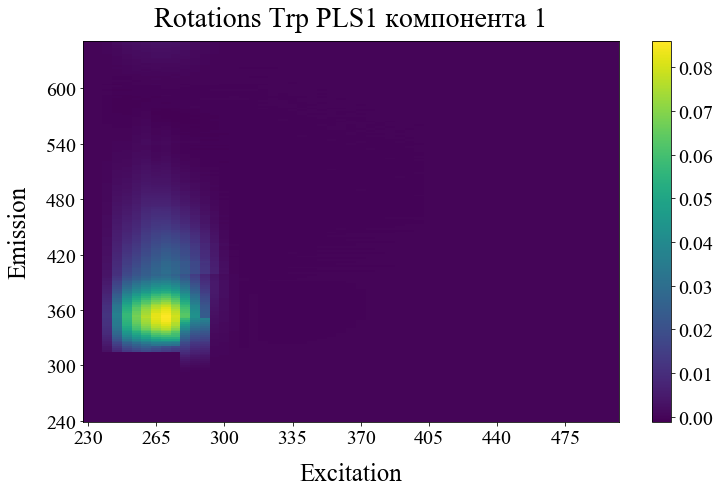

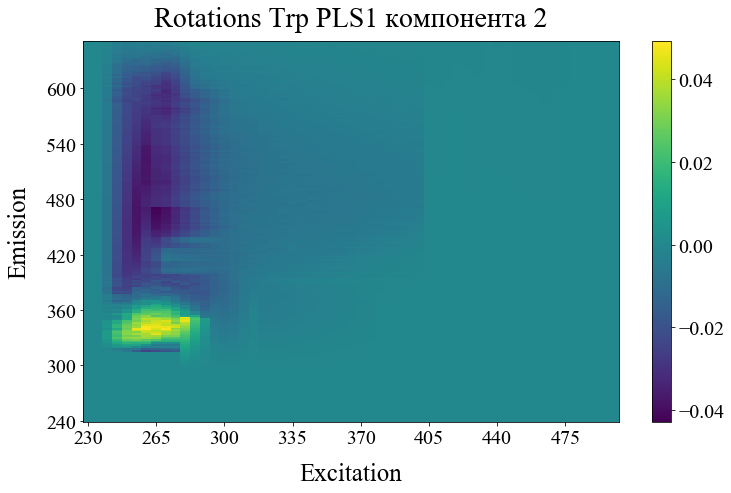

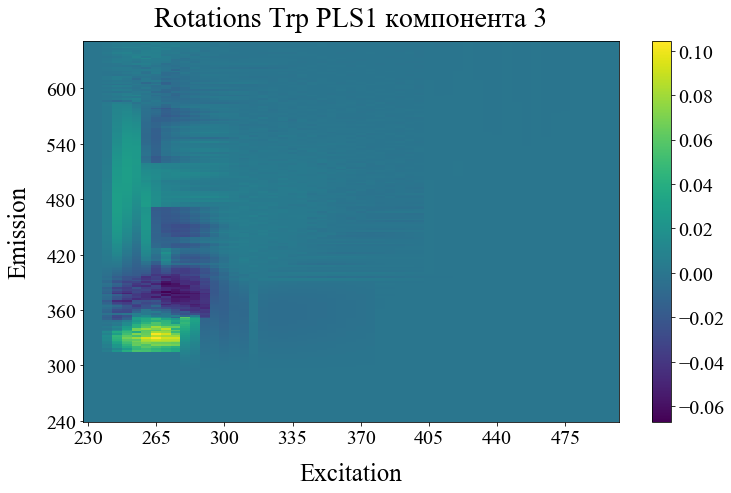

In [373]:
for i in range(0,3):
    mpl.rc('font',family='Times New Roman')
    plt.figure(figsize=(12,7))
    plt.imshow(loadings[:,:,i],aspect="auto", origin='lower')

    plt.title("Rotations Trp PLS1 компонента "+str(i+1),  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
    plt.ylabel("Emission" , fontsize=25,labelpad=15)
    plt.xlabel("Excitation",  fontsize=25,labelpad=15)
    plt.yticks(idi,Xdata_numpy['emission'][idi],fontsize=20)
    plt.xticks(ind,Xdata_numpy['excitation'][ind], fontsize=20)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)

    plt.savefig('Rotations PLS1 для Trp'+str(i)+'.png', format='png', dpi=1024)
plt.show();

In [ ]:
plt.ylabel("Образец" , fontsize=25,labelpad=15)
plt.xlabel("Компонента",  fontsize=25,labelpad=15)

In [355]:
indexi=np.arange(1,11331,2266)

In [356]:
idi=np.arange(0,206,30)

In [357]:
indexx=np.arange(1,4,1)

In [358]:
ind=np.arange(0,55,7)

In [439]:
Xdata_numpy['emission'].shape

(206,)

In [443]:
Xdata_numpy['excitation']

array(['230', '235', '240', '245', '250', '255', '260', '265', '270',
       '275', '280', '285', '290', '295', '300', '305', '310', '315',
       '320', '325', '330', '335', '340', '345', '350', '355', '360',
       '365', '370', '375', '380', '385', '390', '395', '400', '405',
       '410', '415', '420', '425', '430', '435', '440', '445', '450',
       '455', '460', '465', '470', '475', '480', '485', '490', '495',
       '500'], dtype=object)

In [326]:
cvres  = gridCought.cv_results_

#### Попробуем сохранить результаты в пикль формате

In [193]:
pkl.dump(weights,open('C:/Users/admin/Desktop/88/PLS1_Trp_Weights.pkl.gz', 'wb'))

NameError: name 'weights' is not defined

In [133]:
pkl.dump(cvres,open('C:/Users/admin/Desktop/88/PLS1_gomimy.pkl.gz', 'wb'))

In [134]:
pkl.dump(gridCought.best_params_,open('C:/Users/admin/Desktop/88/PLS1_bestparams_gomimy.pkl.gz', 'wb'))

In [135]:
pkl.dump(gridCought.best_estimator_,open('C:/Users/admin/Desktop/88/PLS1_bestestimator_gomimy.pkl.gz', 'wb'))

In [136]:
pkl.dump(gridCought.score,open('C:/Users/admin/Desktop/88/PLS1_bestscore_gomimy.pkl.gz', 'wb'))

In [137]:
pkl.dump(predictors,open('C:/Users/admin/Desktop/88/PLS1_predictors_gomimy.pkl.gz', 'wb'))

In [138]:
pkl.dump(y_test,open('C:/Users/admin/Desktop/88/PLS1_true_meaning_gomimy.pkl.gz', 'wb'))

In [139]:
pkl.dump(y_train,open('C:/Users/admin/Desktop/88/PLS1_train_y_meaning_gomimy.pkl.gz', 'wb'))

### Считываем данные

In [165]:
cvr=pkl.load(open('C:/Users/admin/Desktop/88/PLS1_Trp.pkl.gz', 'rb'))

In [166]:
bestparameters=pkl.load(open('C:/Users/admin/Desktop/88/PLS1_bestparams_Trp.pkl.gz', 'rb'))

In [167]:
best_score=pkl.load(open('C:/Users/admin/Desktop/88/PLS1_bestscore_Trp.pkl.gz', 'rb'))

In [168]:
best_estimator=pkl.load(open('C:/Users/admin/Desktop/88/PLS1_bestestimator_Trp.pkl.gz', 'rb'))

In [169]:
etest=pkl.load(open('C:/Users/admin/Desktop/88/PLS1_true_meaning_Trp.pkl.gz', 'rb'))

In [170]:
etrain=pkl.load(open('C:/Users/admin/Desktop/88/PLS1_train_y_meaning_Trp.pkl.gz', 'rb'))

In [171]:
bestparameters

{'copy': True,
 'max_iter': 10000,
 'n_components': 3,
 'scale': False,
 'tol': 1e-06}

In [48]:
best_score()

<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=PLSRegression(copy=True, max_iter=500, n_components=2,
                                     scale=True, tol=1e-06),
             iid='warn', n_jobs=None,
             param_grid={'copy': [True], 'max_iter': [10000],
                         'n_components': range(1, 85), 'scale': [True, False],
                         'tol': array([1.e-06, 1.e+00, 1.e+06])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)>

In [140]:
gridCought.best_params_

{'copy': True,
 'max_iter': 10000,
 'n_components': 6,
 'scale': True,
 'tol': 1e-06}

In [128]:
max(cvr['mean_test_score'])

0.13713433435992708

In [13]:
ylow=cvr[ "mean_test_score" ]

In [14]:
xlow2=cvr[ "params" ][45]['n_components']

In [15]:
xlow2

8

### train-score

In [16]:
ylow2=cvr[ "mean_train_score" ]

### Строим метки оси ох

In [17]:
xx=np.arange(-100,600,100)

In [18]:
xx

array([-100,    0,  100,  200,  300,  400,  500])

In [348]:
max(ylow)

0.4629646030288301

In [327]:
xlab=[]
mmm=[]
ylow=[]
ylow2=[]

In [328]:
for i in range(0,34):
    if (cvres[ "params" ][i]['scale']==False):
        mmm+=[cvres[ "params" ][i]]
        xlab+=[cvres[ "params" ][i]['n_components']]
        ylow+=[cvres[ "mean_test_score" ][i]]
        ylow2+=[cvres[ "mean_train_score" ][i]]

### Строим метки оси оу

In [336]:
yy=np.arange(-0.8,1.2,0.2)

In [341]:
yy=[ -0.80, -0.6,-0.4,  -0.20,0.0,  0.20, 0.4,  0.60,  0.8, 1.00,1.2 ]

# Графики нового образца

In [332]:
xlab3=[]
for i in np.arange(0,19,2):
    xlab3+=[i]

In [333]:
xlab

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

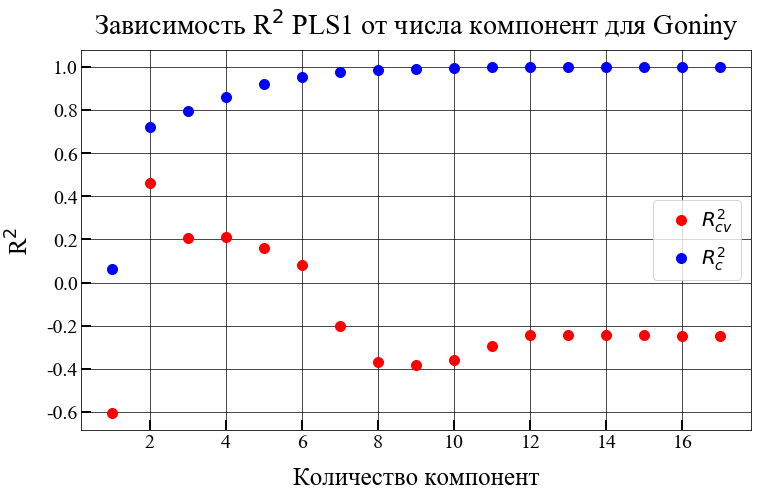

In [345]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(xlab,ylow,".",color="red",ms=20,label='$R_{cv}^{2}$')
axs.plot(xlab,ylow2,".",color="blue",ms=20,label='$R_c^{2}$')
axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=12)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ PLS1 от числа компонент для Goniny", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(xlab3, fontsize=20)
axs.set_yticklabels(yy, fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

plt.savefig('Зависимость score от параметров для PLS1_Goniny.png', format='png', dpi=1024)
plt.show();

In [62]:
axs.set_xticklabels(xlab, fontsize=20)
axs.set_yticklabels(yy, fontsize=20)

Object `fig.get_xaxis().set_tick_params` not found.


In [43]:
yy=np.arange(-1,1.25,0.25)

In [44]:
yy=[-1.0 , -0.75, -0.5 , -0.25,  0.0 ,  0.25,  0.5 ,  0.75,  1.0,1.25  ]

In [ ]:
### Предикт референс график нового образца

In [189]:
yy=np.arange(0.5,6,0.5)

In [190]:
xlab6=np.arange(0.5,6,0.5)

# Оценим правильность на тестовом наборе

In [115]:
print("Правильность на тестовом наборе: {:.2f}".format(gridCought.score(X_test, y_test)))

Правильность на тестовом наборе: nan


In [116]:
print("Наилучшее значение кросс-валидац. правильности: {:.2f}".format(gridCought.best_score_))

Наилучшее значение кросс-валидац. правильности: 0.32


In [117]:
from  sklearn.metrics import  mean_squared_error
final_mse = mean_squared_error (y_test,  predictors) 
final_rmse  =  np.sqrt(final_mse)  
print(final_rmse)

3.0825621365425135


In [118]:
from  sklearn.metrics import accuracy_score
print(gridCought.accuracy_score(y_test,  predictors))

AttributeError: 'GridSearchCV' object has no attribute 'accuracy_score'

In [119]:
print(predictors)
print(y_test)

[[42.98438284]]
31    39.901821
Name: Gominy, dtype: float64


# Построим график для визуализации результатов

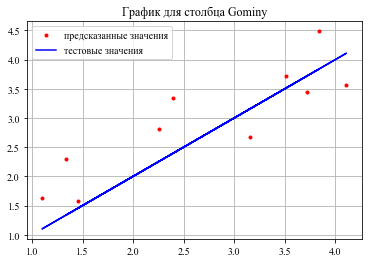

In [81]:
b=[]
for  i in range(0,5):
    b+=[i]
plt.plot(y_test,predictors, ".",color="red",label="предсказанные значения")
plt.plot(y_test,y_test,color="blue", label="тестовые значения")
plt.legend()
plt.grid(True)
plt.title("График для столбца Gominy")
plt.show();

In [153]:
area3x=np.arange(1,4.5,0.5)

In [154]:
area3y=np.arange(0,5,0.5)

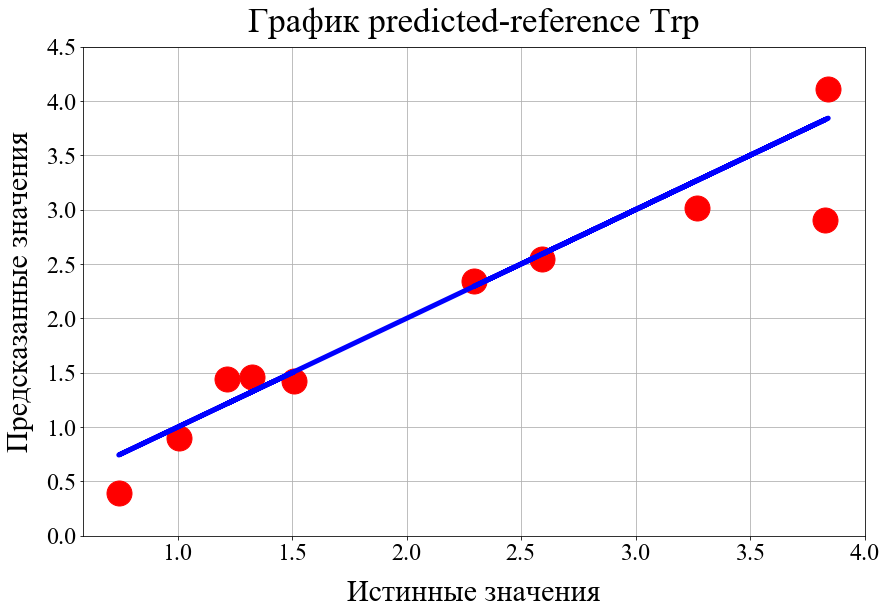

In [156]:
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(14,9))
plt.plot(y_test,predictors, ".",color="red",ms=50)
plt.plot(y_test,y_test,color="blue",lw=5)

plt.ylabel("Предсказанные значения" , fontsize=30,labelpad=12)
plt.grid()
plt.xlabel("Истинные значения",  fontsize=30,labelpad=15)
plt.title("График predicted-reference Trp", fontsize=35,loc="center" ,pad=15)


plt.yticks(area3y,fontsize=24)
plt.xticks(area3x,fontsize=24)
plt.savefig('График predicted-reference Trp.jpeg', format='png', dpi=1000)
plt.show();

# Возьмём матрицу нагрузок

In [442]:
?gridCought

In [171]:
gridCought.coef_

AttributeError: 'GridSearchCV' object has no attribute 'coef_'